In [1]:
#!pip install pandas
#!pip install numpy
#!pip install seaborn
#!pip install matplotlib

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()

# Optimiza los gráficos para pantalla retina
%config InlineBackend.figure_format = 'retina'
# Por defecto usamos el backend inline
%matplotlib inline

# La libreta ocupa así el 95% de la pantalla
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

1.- Carga de datos

In [2]:
df_dosificaciones = pd.read_csv('datos/datos.zip', compression='zip', \
                    sep=',', na_values='\\N', index_col='codigo', \
                    parse_dates=['fecha_inicio', 'fecha_fin'])
df_dosificaciones.head(5)

,fecha_inicio,fecha_fin,cantidad_solicitada,cantidad_dosificada,mezcla,pesada,peso_inicial,manual,id_lote_destino,materia_origen,materia_destino,id_silo,tipo_materia,tipo_destino,densidad,tam_mezcla,desviacion
codigo,,,,,,,,,,,,,,,,,
1308958,2018-01-01 21:58:18,2018-01-01 22:00:15,1600.078404,1606.0,1,0,-12,0,232527,8,285,1,Prima,Formula,1,4000,5.921596
1308975,2018-01-01 22:05:50,2018-01-01 22:07:48,1600.078404,1602.0,2,0,-21,0,232527,8,285,1,Prima,Formula,1,4000,1.921596
1308987,2018-01-01 22:13:08,2018-01-01 22:15:06,1600.078404,1596.0,3,0,-29,0,232527,8,285,1,Prima,Formula,1,4000,-4.078404
1309003,2018-01-01 22:20:17,2018-01-01 22:22:15,1600.078404,1600.0,4,0,-29,0,232527,8,285,1,Prima,Formula,1,4000,-0.078404
1309022,2018-01-01 22:27:53,2018-01-01 22:29:52,1600.078404,1598.0,5,0,-29,0,232527,8,285,1,Prima,Formula,1,4000,-2.078404


2.- Exploracion de datos

In [3]:
df_dosificaciones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 419998 entries, 1308958 to 3014892
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   fecha_inicio         419998 non-null  datetime64[ns]
 1   fecha_fin            419998 non-null  datetime64[ns]
 2   cantidad_solicitada  419998 non-null  float64       
 3   cantidad_dosificada  419998 non-null  float64       
 4   mezcla               419998 non-null  int64         
 5   pesada               419998 non-null  int64         
 6   peso_inicial         419998 non-null  int64         
 7   manual               419998 non-null  int64         
 8   id_lote_destino      419998 non-null  int64         
 9   materia_origen       419998 non-null  int64         
 10  materia_destino      419998 non-null  int64         
 11  id_silo              419998 non-null  int64         
 12  tipo_materia         419998 non-null  object        
 13  tipo_de

3.- Calculamos la duración de cada dosificación

In [4]:
df_dosificaciones['duracion'] = df_dosificaciones['fecha_fin'] - df_dosificaciones['fecha_inicio']
df_dosificaciones['duracion'] = df_dosificaciones['duracion'].dt.seconds

In [5]:
df_dosificaciones.head()

,fecha_inicio,fecha_fin,cantidad_solicitada,cantidad_dosificada,mezcla,pesada,peso_inicial,manual,id_lote_destino,materia_origen,materia_destino,id_silo,tipo_materia,tipo_destino,densidad,tam_mezcla,desviacion,duracion
codigo,,,,,,,,,,,,,,,,,,
1308958,2018-01-01 21:58:18,2018-01-01 22:00:15,1600.078404,1606.0,1,0,-12,0,232527,8,285,1,Prima,Formula,1,4000,5.921596,117
1308975,2018-01-01 22:05:50,2018-01-01 22:07:48,1600.078404,1602.0,2,0,-21,0,232527,8,285,1,Prima,Formula,1,4000,1.921596,118
1308987,2018-01-01 22:13:08,2018-01-01 22:15:06,1600.078404,1596.0,3,0,-29,0,232527,8,285,1,Prima,Formula,1,4000,-4.078404,118
1309003,2018-01-01 22:20:17,2018-01-01 22:22:15,1600.078404,1600.0,4,0,-29,0,232527,8,285,1,Prima,Formula,1,4000,-0.078404,118
1309022,2018-01-01 22:27:53,2018-01-01 22:29:52,1600.078404,1598.0,5,0,-29,0,232527,8,285,1,Prima,Formula,1,4000,-2.078404,119


4.- Calculamos el orden de cada dosificacion dentro de cada mezcla

In [6]:
df_dosificaciones = df_dosificaciones.sort_values(['codigo'])
df_dosificaciones['orden'] = 0
hskeys = {}
for key, row in df_dosificaciones.iterrows():
    hskey = str(row['mezcla'])+"-"+str(row['id_lote_destino'])+"-"+str(row['pesada'])
    valor = 0
    if (hskey in hskeys):
        valor = hskeys[hskey]
    
    hskeys[hskey] = valor + 1
    df_dosificaciones['orden'][key] = hskeys[hskey]

/Users/jlcasado/MCIDAEN/mc1-tfm/venv/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [7]:
# Guardo los datos por ahorrar tiempo en posteriores pruebas
df_dosificaciones.to_csv('datos/data_parser.zip', compression='zip')

In [8]:
df_dosificaciones = pd.read_csv('datos/data_parser.zip', compression='zip', \
                    sep=',', na_values='\\N', index_col='codigo', \
                    parse_dates=['fecha_inicio', 'fecha_fin'])

In [9]:
df_dosificaciones.isnull().sum()

fecha_inicio           0
fecha_fin              0
cantidad_solicitada    0
cantidad_dosificada    0
mezcla                 0
pesada                 0
peso_inicial           0
manual                 0
id_lote_destino        0
materia_origen         0
materia_destino        0
id_silo                0
tipo_materia           0
tipo_destino           0
densidad               0
tam_mezcla             0
desviacion             0
duracion               0
orden                  0
dtype: int64

5.- Miro los valores unicos para variables con pocos valores (Todas esta columanas serán desechadas ya que no aportan gran informacion)

In [10]:
for col in df_dosificaciones:
    if (df_dosificaciones[col].nunique() < 5):
        print(col + ": ")
        print(df_dosificaciones[col].unique())

pesada: 
[0 1]
manual: 
[0]
tipo_materia: 
['Prima']
tipo_destino: 
['Formula']
densidad: 
[1]


6.- Obtengo los estadisticos de las variables numericas

In [11]:
df_dosificaciones[['cantidad_solicitada','cantidad_dosificada', \
                   'peso_inicial','tam_mezcla', 'duracion', 'desviacion']].describe()

,cantidad_solicitada,cantidad_dosificada,peso_inicial,tam_mezcla,duracion,desviacion
count,419998.000000,419998.000000,419998.000000,419998.000000,419998.000000,419998.000000
mean,790.988597,791.457719,1348.815580,4000.872390,39.724856,0.469122
std,740.677947,740.723612,1250.598749,211.039686,47.907401,13.200351
min,0.000000,0.000000,-64.000000,400.000000,0.000000,-1848.190362
25%,160.000000,162.000000,11.000000,4000.000000,16.000000,-3.166597
50%,639.993600,651.000000,1577.000000,4000.000000,25.000000,0.007899
75%,1162.392137,1163.000000,2602.000000,4040.000000,50.000000,3.349073
max,3121.984940,3127.000000,3995.000000,4500.000000,9601.000000,1179.891694


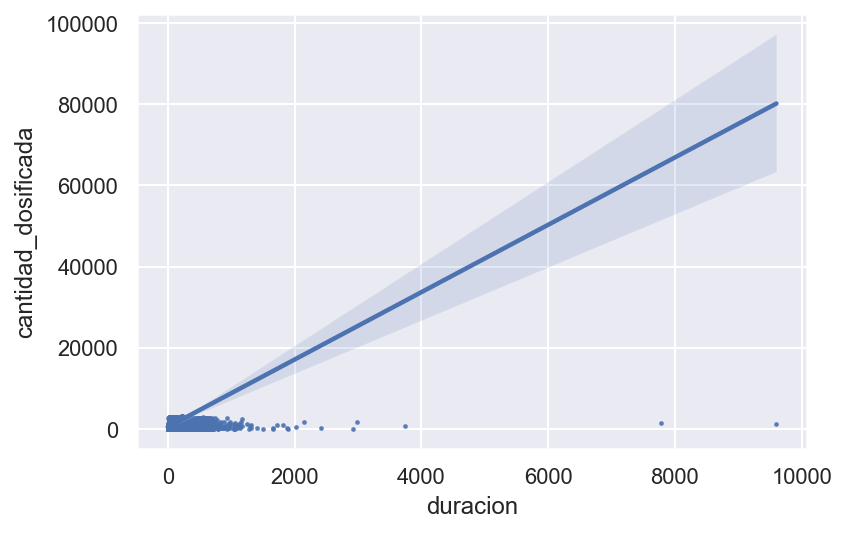

In [13]:
sns.regplot(data=df_dosificaciones, x='duracion', y='cantidad_dosificada', scatter_kws={'s':2});

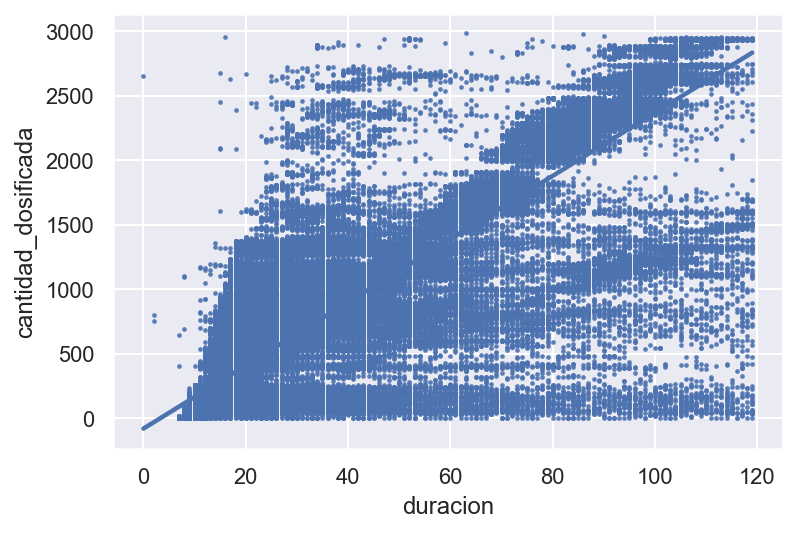

In [17]:
sns.regplot(data=df_dosificaciones[df_dosificaciones['duracion']<120], x='duracion', y='cantidad_dosificada', scatter_kws={'s':2});

In [19]:
df_dosificaciones = df_dosificaciones[df_dosificaciones['duracion']<120]

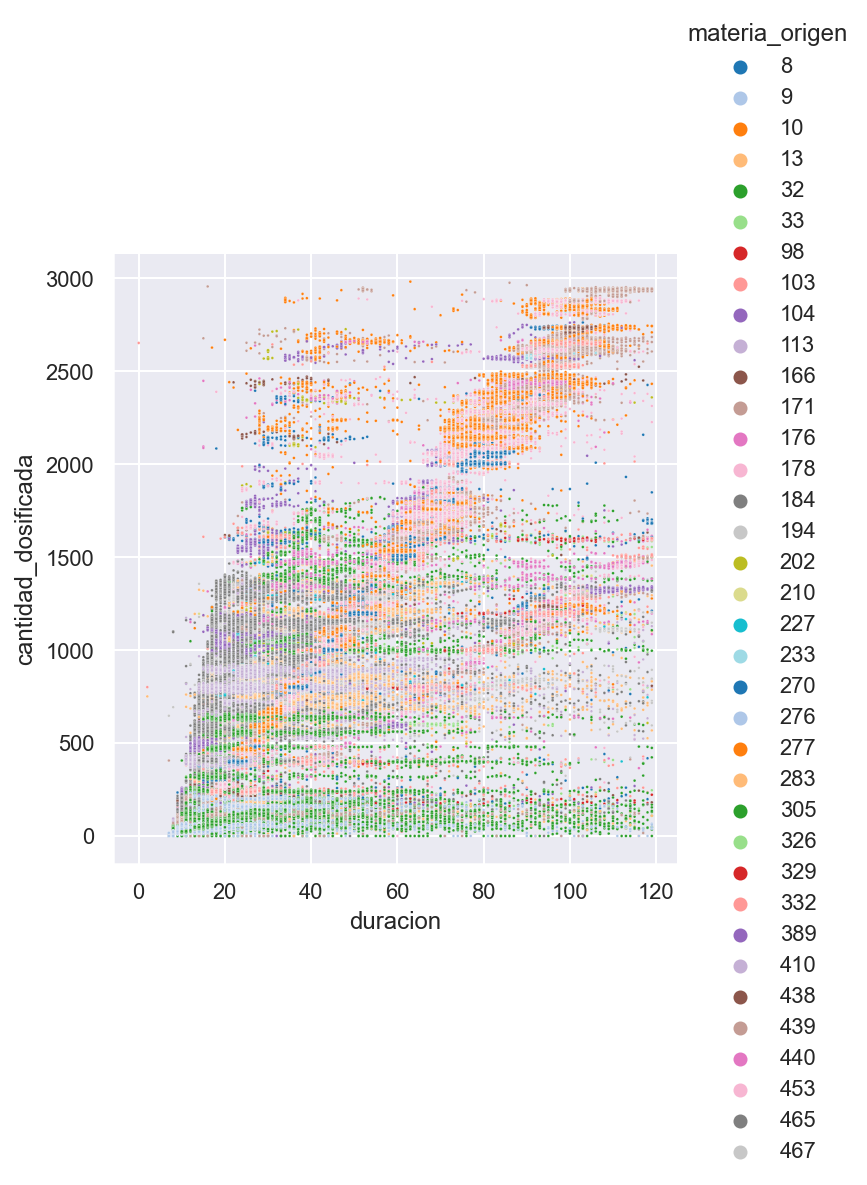

In [24]:
sns.relplot(data=df_dosificaciones, x='duracion', y='cantidad_dosificada', 
            s=2, hue='materia_origen', palette='tab20');

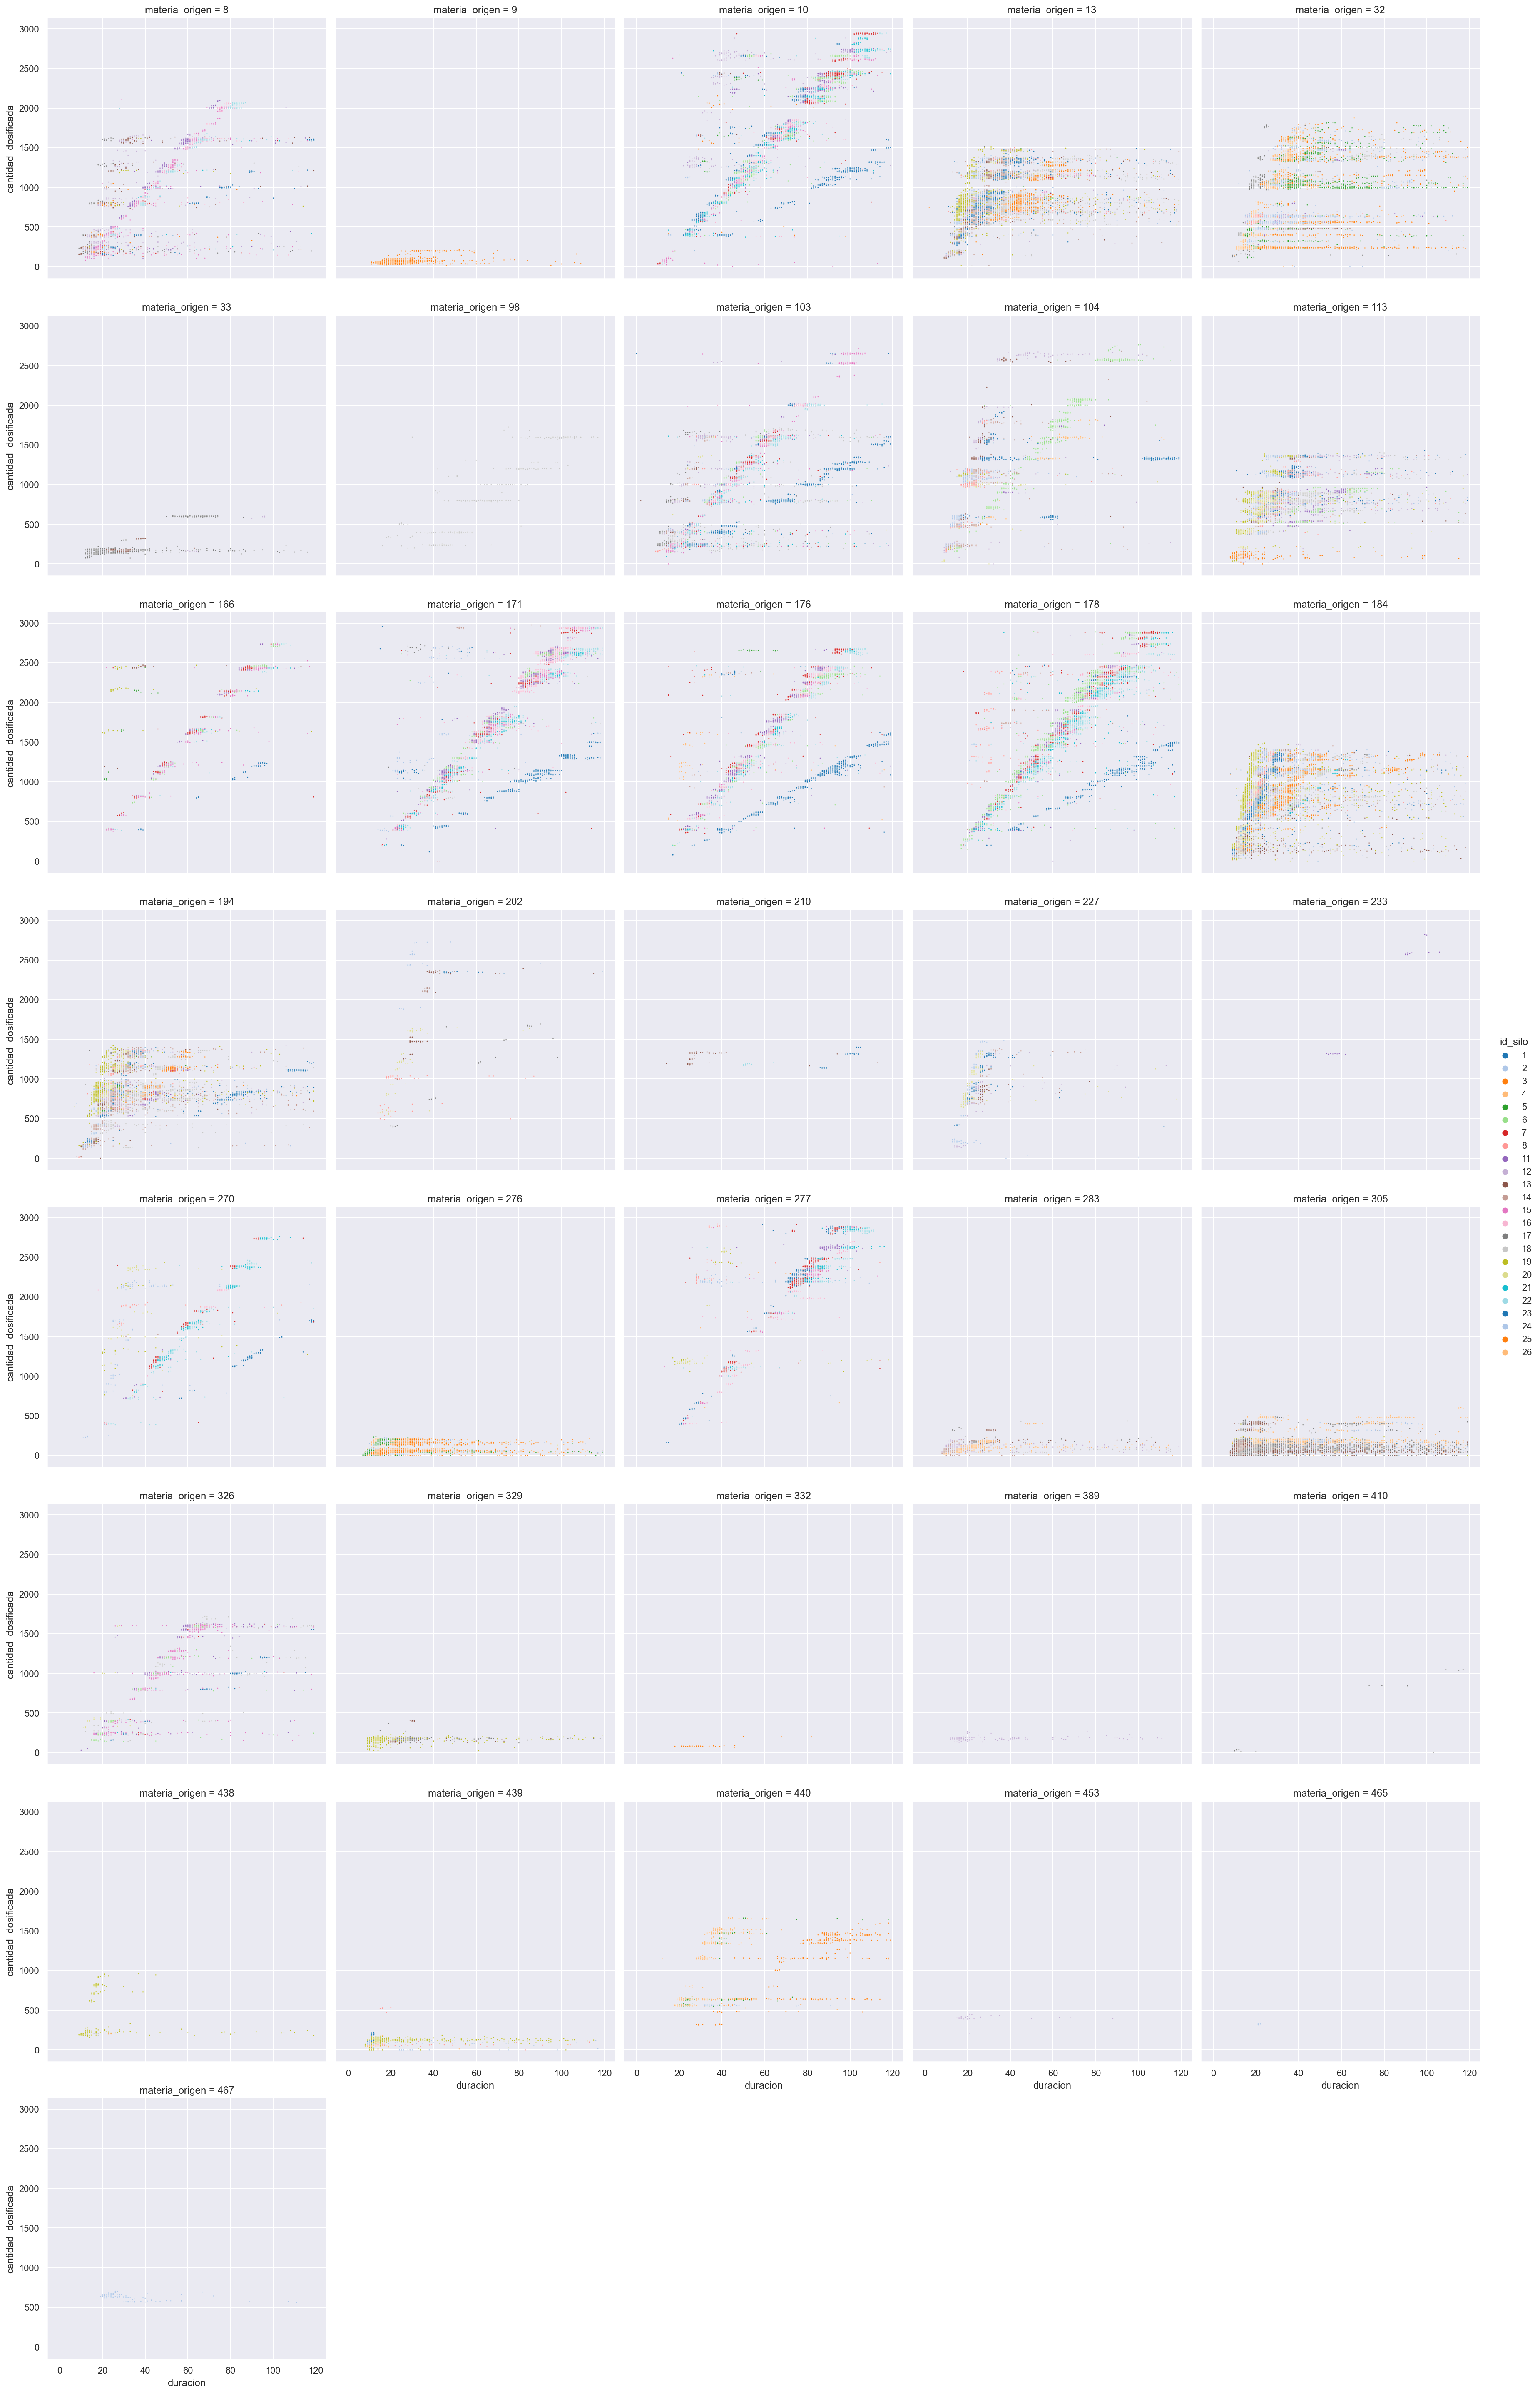

In [25]:
sns.relplot(data=df_dosificaciones, x='duracion', y='cantidad_dosificada', 
            s=2, hue='id_silo', col= 'materia_origen', col_wrap=5,  palette='tab20');

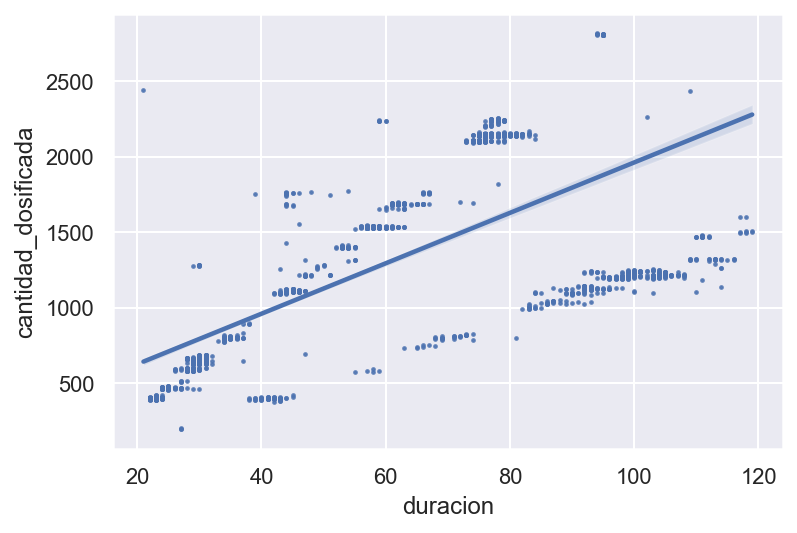

In [27]:
sns.regplot(data=df_dosificaciones[(df_dosificaciones['materia_origen']==10) & 
                                   (df_dosificaciones['id_silo']==1)], x='duracion', y='cantidad_dosificada', scatter_kws={'s':2});

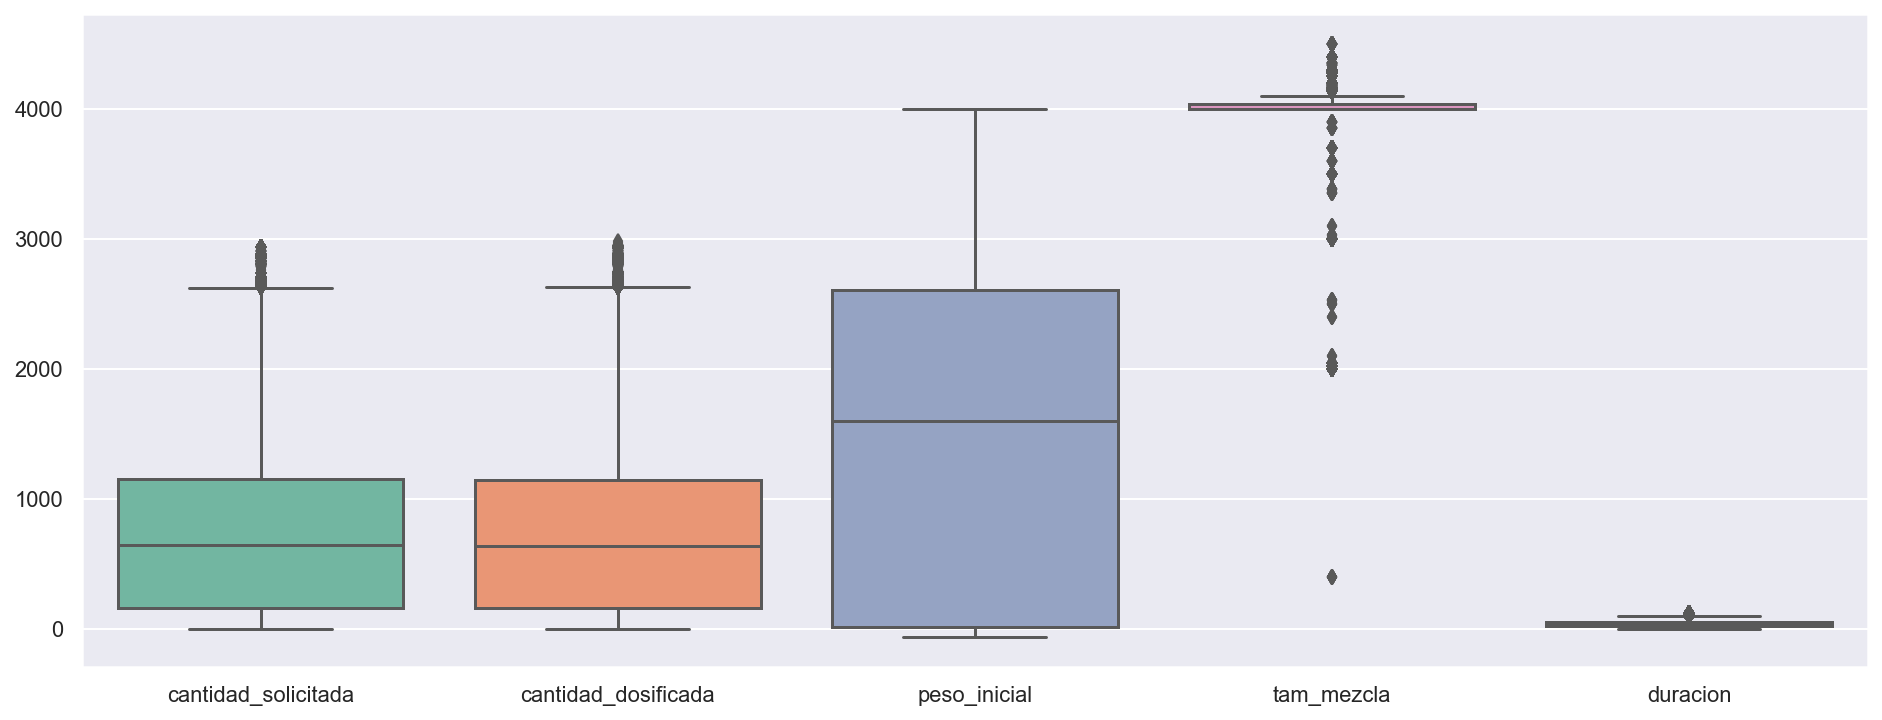

In [23]:
plt.figure(figsize=(16, 6))
sns.boxplot(data=df_dosificaciones[['cantidad_solicitada','cantidad_dosificada','peso_inicial','tam_mezcla', 'duracion']], palette="Set2")

plt.show()

7.- Filtrado de los datos que pueden producir ruido

In [57]:
df_dosificaciones = df_dosificaciones[(df_dosificaciones['cantidad_solicitada'] > 0) &
                  (df_dosificaciones['cantidad_solicitada'] < 2500) &
                  (df_dosificaciones['cantidad_dosificada'] > 1) &
                  (df_dosificaciones['cantidad_dosificada'] < 3000) &
                  (df_dosificaciones['desviacion'] > -40) &
                  (df_dosificaciones['desviacion'] < 40) &
                  (df_dosificaciones['peso_inicial'] < 3000) &
                  (df_dosificaciones['duracion'].dt.total_seconds() < 60)]

In [14]:
df_dosificaciones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 315201 entries, 1308966 to 3211250
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype          
---  ------               --------------   -----          
 0   fecha_inicio         315201 non-null  datetime64[ns] 
 1   fecha_fin            315201 non-null  datetime64[ns] 
 2   cantidad_solicitada  315201 non-null  float64        
 3   cantidad_dosificada  315201 non-null  float64        
 4   mezcla               315201 non-null  int64          
 5   pesada               315201 non-null  int64          
 6   peso_inicial         315201 non-null  int64          
 7   manual               315201 non-null  int64          
 8   id_lote_destino      315201 non-null  int64          
 9   materia_origen       315201 non-null  int64          
 10  materia_destino      315201 non-null  int64          
 11  id_silo              315201 non-null  int64          
 12  tipo_materia         315201 non-null  object       

8.- Eliminación de columnas que no aportan información

In [58]:
columns_delete = ['fecha_fin','cantidad_dosificada', \
                  'manual','densidad','tipo_materia', \
                  'tipo_destino','id_lote_destino']
df_dosificaciones.drop(columns=columns_delete, inplace=True)

In [16]:
df_dosificaciones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 315201 entries, 1308966 to 3211250
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype          
---  ------               --------------   -----          
 0   fecha_inicio         315201 non-null  datetime64[ns] 
 1   cantidad_solicitada  315201 non-null  float64        
 2   mezcla               315201 non-null  int64          
 3   pesada               315201 non-null  int64          
 4   peso_inicial         315201 non-null  int64          
 5   materia_origen       315201 non-null  int64          
 6   materia_destino      315201 non-null  int64          
 7   id_silo              315201 non-null  int64          
 8   tam_mezcla           315201 non-null  int64          
 9   desviacion           315201 non-null  float64        
 10  duracion             315201 non-null  timedelta64[ns]
 11  orden                315201 non-null  int64          
dtypes: datetime64[ns](1), float64(2), int64(8), timedel

9.- Creo que la hora y el dia de la semana pueden influir en la predicción por lo que añado las caracteristicas.

In [59]:
#df_dosificaciones['mes'] = pd.DatetimeIndex(df_dosificaciones['fecha_inicio']).month
#df_dosificaciones['dia'] = pd.DatetimeIndex(df_dosificaciones['fecha_inicio']).day
df_dosificaciones['hora'] = pd.DatetimeIndex(df_dosificaciones['fecha_inicio']).hour
df_dosificaciones['dow'] = pd.DatetimeIndex(df_dosificaciones['fecha_inicio']).dayofweek

In [54]:
df_dosificaciones.head(5)

,fecha_inicio,cantidad_solicitada,mezcla,pesada,peso_inicial,materia_origen,materia_destino,id_silo,tam_mezcla,desviacion,duracion,orden,hora,dow,duracion2
codigo,,,,,,,,,,,,,,,
1308966,2018-01-01 22:00:15,1187.738199,1,0,1592,176,285,15,4000,20.261801,0 days 00:00:53,2,22,0,53.0
1308971,2018-01-01 22:01:08,180.008820,1,0,2799,33,285,17,4000,-2.008820,0 days 00:00:19,3,22,0,19.0
1308973,2018-01-01 22:02:11,768.557659,1,1,2,184,285,14,4000,-5.557659,0 days 00:00:41,1,22,0,41.0
1308978,2018-01-01 22:07:49,1187.738199,2,0,1581,176,285,15,4000,0.261801,0 days 00:00:46,2,22,0,46.0
1308980,2018-01-01 22:08:36,180.008820,2,0,2769,33,285,17,4000,0.991180,0 days 00:00:21,3,22,0,21.0


Convertimos la columna TimeDelta a nanosegundos

In [60]:
df_dosificaciones['duracion'] = df_dosificaciones['duracion'].dt.total_seconds()

In [61]:
df_dosificaciones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 315201 entries, 1308966 to 3211250
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   fecha_inicio         315201 non-null  datetime64[ns]
 1   cantidad_solicitada  315201 non-null  float64       
 2   mezcla               315201 non-null  int64         
 3   pesada               315201 non-null  int64         
 4   peso_inicial         315201 non-null  int64         
 5   materia_origen       315201 non-null  int64         
 6   materia_destino      315201 non-null  int64         
 7   id_silo              315201 non-null  int64         
 8   tam_mezcla           315201 non-null  int64         
 9   desviacion           315201 non-null  float64       
 10  duracion             315201 non-null  float64       
 11  orden                315201 non-null  int64         
 12  hora                 315201 non-null  int64         
 13  dow    

10.- Carga de datos obtenidos de aemet, al ser diarios posteriormente pasaremos la fecha de los datos de las
dosificaciones tambien a fechas diarias.

In [62]:
df_meteo = pd.read_csv('datos/datosMeteo.csv', \
                    sep=',', na_values='\\N',  \
                    parse_dates=['fecha','horatmin','horatmax','horaracha'])
df_meteo.rename(columns={'fecha':'fecha_inicio'}, inplace=True)
df_meteo.head(5)

,fecha_inicio,nombre,provincia,altitud,tmed,prec,tmin,horatmin,tmax,horatmax,dir,velmedia,racha,horaracha
0,2018-01-01,CARTAGENA,MURCIA,17,14.1,0.0,10.8,2018-01-01 08:00:00,17.4,2018-01-01 00:10:00,19,1.7,9.7,2018-01-01 15:10:00
1,2018-01-01,SAN JAVIER AEROPUERTO,MURCIA,4,13.8,0.0,8.2,2018-01-01 22:06:00,19.3,2018-01-01 11:51:00,32,4.7,12.8,2018-01-01 00:22:00
2,2018-01-02,CARTAGENA,MURCIA,17,14.3,0.0,10.2,2018-01-02 08:00:00,18.4,2018-01-02 12:20:00,18,1.1,4.7,2018-01-02 14:50:00
3,2018-01-02,SAN JAVIER AEROPUERTO,MURCIA,4,15.4,0.0,8.0,2018-01-02 02:58:00,22.7,2018-01-02 14:28:00,30,4.7,11.7,2018-01-02 23:45:00
4,2018-01-03,CARTAGENA,MURCIA,17,16.0,0.0,11.7,2018-01-03 05:00:00,20.3,2018-01-03 15:10:00,16,0.8,6.4,2018-01-03 16:00:00


Hemos obtenido la informacion meteorologica de las dos estaciones mas cercanas a la fabrica, y mas o menos estan a la misma distancia, 
quedando etre ellas la propia fabrica, por lo que calcularemos la media de los valores de las dos.

In [63]:
df_meteo_group = df_meteo.groupby(['fecha_inicio']).mean()
df_meteo_group.head()

,altitud,tmed,prec,tmin,tmax,dir,velmedia,racha
fecha_inicio,,,,,,,,
2018-01-01,10.5,13.95,0.0,9.5,18.35,25.5,3.20,11.25
2018-01-02,10.5,14.85,0.0,9.1,20.55,24.0,2.90,8.20
2018-01-03,10.5,17.70,0.0,12.7,22.70,24.0,2.35,10.15
2018-01-04,10.5,15.85,0.0,11.0,20.70,23.0,1.70,11.25
2018-01-05,10.5,13.20,0.0,8.0,18.45,18.0,1.65,5.85


Nos quedamos solo con los datos del dia en nuestra fecha de las dosificaciones para hacer el merge con nuestra tabla de datos meteorologicos

In [64]:
df_dosificaciones['fecha_inicio'] = df_dosificaciones['fecha_inicio'].dt.normalize()

In [65]:
df_dosificaciones = pd.merge(df_dosificaciones, df_meteo_group, on='fecha_inicio')

In [66]:
df_dosificaciones.head()

,fecha_inicio,cantidad_solicitada,mezcla,pesada,peso_inicial,materia_origen,materia_destino,id_silo,tam_mezcla,desviacion,...,hora,dow,altitud,tmed,prec,tmin,tmax,dir,velmedia,racha
0,2018-01-01,1187.738199,1,0,1592,176,285,15,4000,20.261801,...,22,0,10.5,13.95,0.0,9.5,18.35,25.5,3.2,11.25
1,2018-01-01,180.008820,1,0,2799,33,285,17,4000,-2.008820,...,22,0,10.5,13.95,0.0,9.5,18.35,25.5,3.2,11.25
2,2018-01-01,768.557659,1,1,2,184,285,14,4000,-5.557659,...,22,0,10.5,13.95,0.0,9.5,18.35,25.5,3.2,11.25
3,2018-01-01,1187.738199,2,0,1581,176,285,15,4000,0.261801,...,22,0,10.5,13.95,0.0,9.5,18.35,25.5,3.2,11.25
4,2018-01-01,180.008820,2,0,2769,33,285,17,4000,0.991180,...,22,0,10.5,13.95,0.0,9.5,18.35,25.5,3.2,11.25


In [67]:
df_dosificaciones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314503 entries, 0 to 314502
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   fecha_inicio         314503 non-null  datetime64[ns]
 1   cantidad_solicitada  314503 non-null  float64       
 2   mezcla               314503 non-null  int64         
 3   pesada               314503 non-null  int64         
 4   peso_inicial         314503 non-null  int64         
 5   materia_origen       314503 non-null  int64         
 6   materia_destino      314503 non-null  int64         
 7   id_silo              314503 non-null  int64         
 8   tam_mezcla           314503 non-null  int64         
 9   desviacion           314503 non-null  float64       
 10  duracion             314503 non-null  float64       
 11  orden                314503 non-null  int64         
 12  hora                 314503 non-null  int64         
 13  dow           

In [68]:
columns_delete = ['fecha_inicio','altitud', \
                  'dir','velmedia','racha']
df_dosificaciones.drop(columns=columns_delete, inplace=True)

In [69]:
df_dosificaciones.head()

,cantidad_solicitada,mezcla,pesada,peso_inicial,materia_origen,materia_destino,id_silo,tam_mezcla,desviacion,duracion,orden,hora,dow,tmed,prec,tmin,tmax
0,1187.738199,1,0,1592,176,285,15,4000,20.261801,53.0,2,22,0,13.95,0.0,9.5,18.35
1,180.008820,1,0,2799,33,285,17,4000,-2.008820,19.0,3,22,0,13.95,0.0,9.5,18.35
2,768.557659,1,1,2,184,285,14,4000,-5.557659,41.0,1,22,0,13.95,0.0,9.5,18.35
3,1187.738199,2,0,1581,176,285,15,4000,0.261801,46.0,2,22,0,13.95,0.0,9.5,18.35
4,180.008820,2,0,2769,33,285,17,4000,0.991180,21.0,3,22,0,13.95,0.0,9.5,18.35


11.- Miro la correlacion entre las variables.

In [70]:
df_dosificaciones.corr()

,cantidad_solicitada,mezcla,pesada,peso_inicial,materia_origen,materia_destino,id_silo,tam_mezcla,desviacion,duracion,orden,hora,dow,tmed,prec,tmin,tmax
cantidad_solicitada,1.000000,-0.123482,0.391461,-0.761115,-0.441374,0.132239,0.152834,0.011023,0.006919,0.739628,-0.723270,0.053276,-0.014628,-0.038303,-0.009261,-0.035641,-0.039550
mezcla,-0.123482,1.000000,-0.030568,0.092156,0.011685,-0.225281,-0.043962,0.005778,-0.011426,-0.138647,0.096472,-0.250400,0.076045,0.037215,0.012687,0.036556,0.036260
pesada,0.391461,-0.030568,1.000000,-0.827793,-0.275951,0.027335,0.286931,0.029176,0.023532,0.107300,-0.642162,0.025672,-0.017744,0.020968,0.009784,0.024012,0.016742
peso_inicial,-0.761115,0.092156,-0.827793,1.000000,0.427836,-0.073443,-0.249434,0.081796,-0.016991,-0.462381,0.838291,-0.045800,0.021097,0.024986,-0.001541,0.022090,0.027093
materia_origen,-0.441374,0.011685,-0.275951,0.427836,1.000000,0.046220,-0.021271,0.033554,0.030858,-0.337777,0.501742,-0.023741,0.001322,0.019596,0.004643,0.023779,0.014043
materia_destino,0.132239,-0.225281,0.027335,-0.073443,0.046220,1.000000,0.038864,0.006206,-0.000136,0.142977,-0.060340,0.091418,-0.053832,-0.076437,-0.000387,-0.080788,-0.068543
id_silo,0.152834,-0.043962,0.286931,-0.249434,-0.021271,0.038864,1.000000,-0.025558,-0.007911,0.100545,-0.308247,0.019899,-0.028587,-0.017294,0.003214,-0.022302,-0.011018
tam_mezcla,0.011023,0.005778,0.029176,0.081796,0.033554,0.006206,-0.025558,1.000000,0.000431,-0.011758,0.026904,-0.025010,0.032961,0.103329,0.009019,0.101357,0.101505
desviacion,0.006919,-0.011426,0.023532,-0.016991,0.030858,-0.000136,-0.007911,0.000431,1.000000,-0.039419,-0.004074,-0.001038,0.001045,0.003691,-0.003512,0.006676,0.000134
duracion,0.739628,-0.138647,0.107300,-0.462381,-0.337777,0.142977,0.100545,-0.011758,-0.039419,1.000000,-0.511003,0.051248,-0.019012,-0.033362,-0.003722,-0.032782,-0.032560


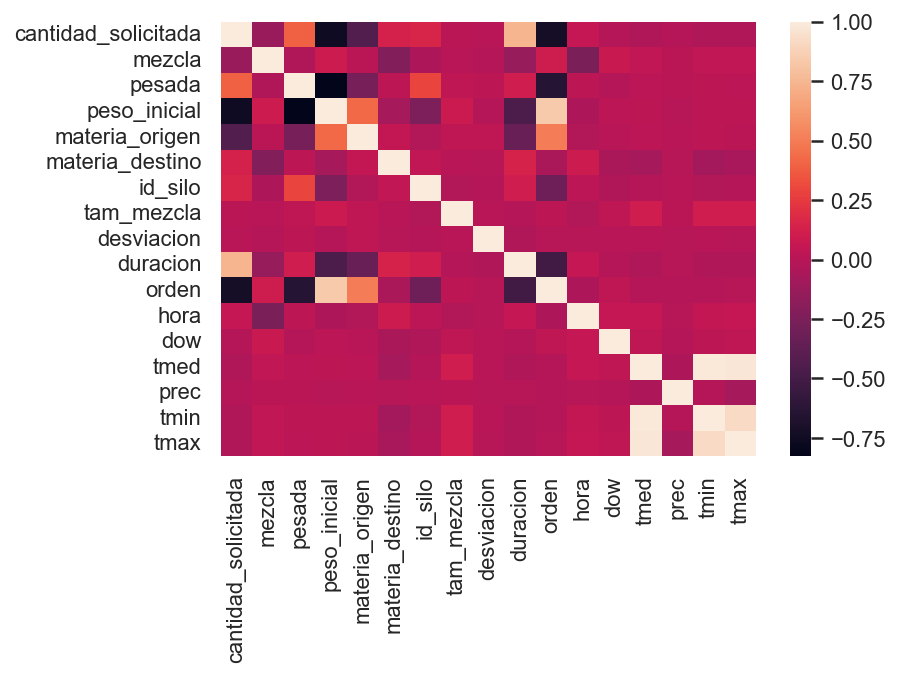

In [71]:
sns.heatmap(df_dosificaciones.corr())
plt.show()

In [24]:
var_numericas = ['cantidad_solicitada','peso_inicial', 'tam_mezcla', 'duracion']

#pg = sns.pairplot(df_dosificaciones.sample(n=10000), vars=var_numericas,  \
#                  plot_kws={'alpha':0.1,'size':.1}, \
#                  diag_kws={'bins':40})

In [25]:
#df_month_pi_des = df_dosificaciones.groupby(['materia_origen','id_silo']).mean()[['peso_inicial','desviacion']]
#df_month_pi_des.head()

In [26]:
#sns.lineplot(data=df_dosificaciones.sample(1000), x='peso_inicial', y='desviacion')

In [27]:
#!pip install sklearn

12.- Guardo los datos definitivos

In [72]:
df_dosificaciones.to_csv('datos/data_clean.zip', compression='zip')

12.- Miro los valores diferentes de las variables para ver cuales pueden ser categoricas

In [73]:
for col in df_dosificaciones:
    print(col + ": " + str(df_dosificaciones[col].nunique()))
    if (df_dosificaciones[col].nunique() < 200):
        print(df_dosificaciones[col].unique())

cantidad_solicitada: 4526
mezcla: 66
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66]
pesada: 2
[0 1]
peso_inicial: 2856
materia_origen: 36
[176  33 184  32   8 305 178 276   9 194 103 113 326 202 270  13 329 332
 277 227  10 166 283 389  98 171 410 210 104 233 439 440 438 467 465 453]
materia_destino: 59
[285 272 264 249  39  26 312  50  41 168 247 217  53 212  58 225 107 319
 323 321 317  48  25 314 118  49  46 215  35  61 278  62  37 310 220 291
  56 114 124 190  60 179 181 222 251 306 308 297 299 186 444 241 244 455
 469 472 478 484 493]
id_silo: 24
[15 17 14 13  2  1 26  7 20  8 25 16 12 23  6 24 21 19 22  3 11 18  4  5]
tam_mezcla: 46
[4000 4060 4040 4080 2000 2020 4010 4200  400 4100 4140 4400 4160 4150
 3030 4020 3000 3700 3500 4008 3005 3100 4250 4028 2525 4300 3380 4180
 4500 4340 4290 3600 4170 4350 2400 3350 3900 2100 2500 

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

cat_features = ['materia_origen', 'materia_destino', 'pesada','id_silo', 'orden', 'hora', 'dow']#'mes', 'dia'
num_features = ['cantidad_solicitada','peso_inicial','tam_mezcla', 'mezcla','duracion']

num_transformer = Pipeline([('imputer',SimpleImputer()),
                            ('standard_scaler', StandardScaler())])

cat_transformer = Pipeline([('simple_imputer', SimpleImputer(strategy='constant')),
                            ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'))])

column_trans = ColumnTransformer(
                transformers=[
                    ('num',num_transformer,num_features),
                    ('cat',cat_transformer,cat_features)])


In [39]:
from sklearn.model_selection import train_test_split

X = df_dosificaciones.drop('desviacion',1)
y = df_dosificaciones['desviacion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

/Users/jlcasado/MCIDAEN/mc1-tfm/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
X.head()

,cantidad_solicitada,mezcla,pesada,peso_inicial,materia_origen,materia_destino,id_silo,tam_mezcla,duracion,orden,hora,dow
codigo,,,,,,,,,,,,
1308966,1187.738199,1,0,1592,176,285,15,4000,0,2,22,0
1308971,180.008820,1,0,2799,33,285,17,4000,0,3,22,0
1308973,768.557659,1,1,2,184,285,14,4000,0,1,22,0
1308978,1187.738199,2,0,1581,176,285,15,4000,0,2,22,0
1308980,180.008820,2,0,2769,33,285,17,4000,0,3,22,0


In [41]:
X_train_prep = column_trans.fit_transform(X_train)
X_test_prep  = column_trans.transform(X_test)

In [42]:
from sklearn.linear_model import LinearRegression

linr_model = LinearRegression()

linr_model.fit(X_train_prep, y_train)

LinearRegression()

In [43]:
from sklearn.metrics import mean_squared_error

y_pred = linr_model.predict(X_train_prep)
y_pred_test = linr_model.predict(X_test_prep)

print("Linear regression")
print("Error de entrenamiento: ", mean_squared_error(y_train, y_pred))
print("Error de test: ", mean_squared_error(y_test, y_pred_test))

Linear regression
Error de entrenamiento:  43.68636991673402
Error de test:  44.17830115489623


In [44]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

lr_model = Ridge();

churn_pipe_lr = Pipeline([('prep', column_trans),
                            ('clas', lr_model)])

In [46]:
parameters = {}
parameters['prep__num__imputer__strategy'] = ['mean', 'median']
parameters['clas__alpha'] = [1,0.1,0.01,0.001,0.0001,0]

X_sample = X_train.sample(n=10000)
y_sample = y_train[X_sample.index]

GS = GridSearchCV(estimator=churn_pipe_lr, param_grid=parameters, scoring='neg_mean_squared_error', cv=5)
GS = GS.fit(X_sample, y_sample)	
    
print("Mejor score: ", GS.best_score_)
print("Mejore configuración de parámetros: ", GS.best_params_)


Mejor score:  -42.994940942993466
Mejore configuración de parámetros:  {'clas__alpha': 1, 'prep__num__imputer__strategy': 'mean'}


In [47]:
ridge_model = Ridge(alpha=1);

ridge_model.fit(X_train_prep, y_train) 

Ridge(alpha=1)

In [48]:
y_pred = ridge_model.predict(X_train_prep)
y_pred_test = ridge_model.predict(X_test_prep)

print("Error de entrenamiento: ", mean_squared_error(y_train, y_pred))
print("Error de test: ", mean_squared_error(y_test, y_pred_test))

Error de entrenamiento:  43.68777432659318
Error de test:  44.17699112567424


In [49]:
import pickle
nombre_modelo = 'modelo_ridge.pkl'

pickle.dump(ridge_model, open(nombre_modelo,'wb'))

In [50]:
loaded_model = pickle.load(open(nombre_modelo, 'rb'))

In [51]:
y_pred = loaded_model.predict(X_test_prep)

In [52]:
print("Ridge")
print("Error de entrenamiento: ", mean_squared_error(y_test, y_pred))

Ridge
Error de entrenamiento:  44.17699112567424


In [53]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold

from sklearn.ensemble import RandomForestRegressor

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('prep', column_trans),
                ('modelo',  RandomForestRegressor())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro

param_distributions = {
    'modelo__n_estimators': [50, 100, 200, 1000],
    'modelo__max_features': ["auto", 3, 5, 7, 10],
    'modelo__max_depth'   : [None, 3, 5, 10, 20]
}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 20,
        scoring    = 'neg_root_mean_squared_error',
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

In [54]:
X_sample = X_train.sample(n=1000)
y_sample = y_train[X_sample.index]

In [55]:
grid.fit(X = X_sample, y = y_sample)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = True)\
    .head(1)

,param_modelo__n_estimators,param_modelo__max_features,param_modelo__max_depth,mean_test_score,std_test_score,mean_train_score,std_train_score
5,50,auto,None,-6.643096,0.327925,-2.519441,0.050758


In [56]:
print("Mejor score: ", grid.best_score_)
print("Mejore configuración de parámetros: ", grid.best_params_)

Mejor score:  -6.379962387335862
Mejore configuración de parámetros:  {'modelo__n_estimators': 100, 'modelo__max_features': 10, 'modelo__max_depth': 10}


In [57]:
rf_model = RandomForestRegressor(n_estimators=100,max_features=10,max_depth=10)

rf_model.fit(X_train_prep, y_train)

RandomForestRegressor(max_depth=10, max_features=10)

In [58]:
y_pred = rf_model.predict(X_train_prep)
y_pred_test = rf_model.predict(X_test_prep)

print("Error de entrenamiento: ", mean_squared_error(y_train, y_pred))
print("Error de test: ", mean_squared_error(y_test, y_pred_test))

Error de entrenamiento:  41.9157143986831
Error de test:  42.79118013855667
